## **Pricing FX Barrier Options and the Binomial Model**

Barrier options are a class of exotic options where the **payoff depends on whether the underlying asset crosses a specified price level (barrier) during the option's lifetime**. These options can either:
- **"Knock-in"** (become activated upon crossing the barrier)
- **"Knock-out"** (become deactivated upon crossing the barrier)

#### **Types of Barrier Options**
1. **Down-and-In** (DI) → Option activates when price **falls below** the barrier.
2. **Down-and-Out** (DO) → Option cancels when price **falls below** the barrier.
3. **Up-and-In** (UI) → Option activates when price **rises above** the barrier.
4. **Up-and-Out** (UO) → Option cancels when price **rises above** the barrier.


### Question: *Why Can't We Use Black-Scholes for Barrier Options?*
The **Black-Scholes model** is based on the assumption that:
1. The **underlying price follows a continuous stochastic process**.
2. The option **depends only on the terminal price** at expiration.
3. There are **no price-dependent barriers** affecting the payoff.

However, **barrier options are path-dependent**—meaning we need to track the entire price evolution, not just the final price at expiration. **This violates the assumptions of Black-Scholes**.

The **Solution** is to utilize a **binomial tree model** can effectively price barrier options by tracking price movements at each time step and **applying knock-in/knock-out conditions**.


### **Binomial Model for Barrier Options**
A binomial tree **models stock prices step-by-step**, allowing us to:
- **Track whether the barrier is breached**.
- **Knock out the option dynamically** in the backward induction process.
- **Compute survival probabilities** to handle knock-in/out behavior.

### **Mathematical Formulation of the Binomial Tree**
- ##### **FX Price Evolution** : At each time step $dt$, the FX price moves: $S_{i+1}^u = S_i \times u, \quad S_{i+1}^d = S_i \times d$
where:
$u = e^{\sigma \sqrt{dt}}, \quad d = \frac{1}{u}$

The **risk-neutral probability** of an **up-move** is: $q = \frac{e^{(r_d - r_f) dt} - d}{u - d}$ and **1-q** of an **down movement**.

- #####  **Option Value Backward Induction**: Using discounted expectation: $P_{i, j} = e^{-r_d dt} \times \left( q \times P_{i+1, j} + (1 - q) \times P_{i+1, j+1} \right)$

If the **barrier condition is met** (knock-out), we set:
$P_{i, j} = 0 $

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import networkx as nx
sys.path.append(os.path.abspath("../src"))
from binomial_barrier_option import BinomialBarrierOption
from black_scholes import BlackScholes
from mpl_toolkits.mplot3d import Axes3D

In [10]:
# Define test parameters
spot_price = 1.40       # Current price of the underlying asset
strike_price = 1.0     # Strike price of the option
barrier_level = 1.10    # Barrier level (for down options)
time_to_maturity = 1    # Time to maturity (in years)
volatility = 0.2        # Volatility (annualized)
domestic_rate = 0.05    # Domestic risk-free interest rate
foreign_rate = 0.04     # Foreign risk-free interest rate
num_steps = 1000         # Steps in binomial tree for accuracy

# Function to price barrier options
def price_barrier_option(option_type, barrier_type):
    return BinomialBarrierOption(
        spot_price, strike_price, time_to_maturity, volatility,
        domestic_rate, foreign_rate, barrier_level, barrier_type, option_type, num_steps
    ).price()

# Compute Black-Scholes vanilla option prices
bs_model = BlackScholes(spot_price, strike_price, time_to_maturity, volatility, domestic_rate, foreign_rate)
call_vanilla_price = bs_model.calculate_vanilla_price("call")
put_vanilla_price = bs_model.calculate_vanilla_price("put")

# Compute barrier option prices efficiently using function
call_prices = {
    "down-in": price_barrier_option("call", "down-in"),
    "down-out": price_barrier_option("call", "down-out"),
    "up-in": price_barrier_option("call", "up-in"),
    "up-out": price_barrier_option("call", "up-out")
}

put_prices = {
    "down-in": price_barrier_option("put", "down-in"),
    "down-out": price_barrier_option("put", "down-out"),
    "up-in": price_barrier_option("put", "up-in"),
    "up-out": price_barrier_option("put", "up-out")
}

# Store results in a DataFrame
results_table = pd.DataFrame({
    "Vanilla Option": ["Call Vanilla", "Call Vanilla", "Put Vanilla", "Put Vanilla"],
    "Barrier Option 1": ["Call (Down-In)", "Call (Up-In)", "Put (Down-In)", "Put (Up-In)"],
    "Price 1": [call_prices["down-in"], call_prices["up-in"], put_prices["down-in"], put_prices["up-in"]],
    "Barrier Option 2": ["Call (Down-Out)", "Call (Up-Out)", "Put (Down-Out)", "Put (Up-Out)"],
    "Price 2": [call_prices["down-out"], call_prices["up-out"], put_prices["down-out"], put_prices["up-out"]],
    "Sum (Barrier 1 + Barrier 2)": [
        call_prices["down-in"] + call_prices["down-out"],
        call_prices["up-in"] + call_prices["up-out"],
        put_prices["down-in"] + put_prices["down-out"],
        put_prices["up-in"] + put_prices["up-out"]
    ],
    "Vanilla Price": [call_vanilla_price, call_vanilla_price, put_vanilla_price, put_vanilla_price],
    "Check: Sum ≈ Vanilla": [
        np.isclose(call_prices["down-in"] + call_prices["down-out"], call_vanilla_price, atol=1e-5),
        np.isclose(call_prices["up-in"] + call_prices["up-out"], call_vanilla_price, atol=1e-5),
        np.isclose(put_prices["down-in"] + put_prices["down-out"], put_vanilla_price, atol=1e-5),
        np.isclose(put_prices["up-in"] + put_prices["up-out"], put_vanilla_price, atol=1e-5)
    ]
})
results_table


,Vanilla Option,Barrier Option 1,Price 1,Barrier Option 2,Price 2,Sum (Barrier 1 + Barrier 2),Vanilla Price,Check: Sum ≈ Vanilla
0,Call Vanilla,Call (Down-In),0.397684,Call (Down-Out),4.912183e-06,0.397688,0.397683,True
1,Call Vanilla,Call (Up-In),0.397684,Call (Up-Out),1.894000e-57,0.397684,0.397683,True
2,Put Vanilla,Put (Down-In),0.003808,Put (Down-Out),0.000000e+00,0.003808,0.003808,True
3,Put Vanilla,Put (Up-In),0.003808,Put (Up-Out),7.106445e-53,0.003808,0.003808,True


#### **Validating Theoretical Identities of Barrier Options**
Barrier options must satisfy the following relationships based on financial theory:

- $\text{Call (Down-In)} + \text{Call (Down-Out)} = \text{Call Vanilla}$

- $\text{Call (Up-In)} + \text{Call (Up-Out)} = \text{Call Vanilla}$

- $\text{Put (Down-In)} + \text{Put (Down-Out)} = \text{Put Vanilla}$

- $\text{Put (Up-In)} + \text{Put (Up-Out)} = \text{Put Vanilla}$

These relationships arise because:
1. A **knock-in option** only becomes active **if the barrier is breached**.
2. A **knock-out option** ceases to exist **if the barrier is breached**.
3. The sum of both options should replicate the **payoff of a vanilla European option**.


The table above verifies whether the **sum of knock-in and knock-out options** correctly approximates the vanilla option price.


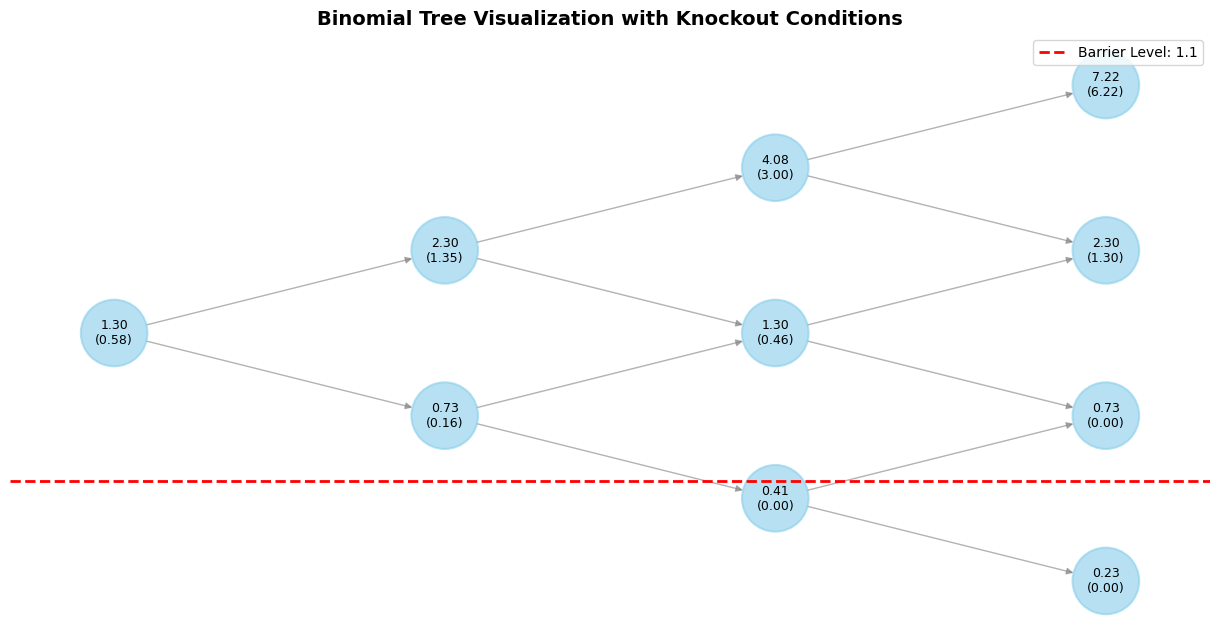

In [27]:
def visualize_binomial_tree(option_model, steps=10):
    """Creates an  visualization of a binomial tree with option prices, time steps,and highlighted nodes for knocked-out options.
    option_model: Instance of BinomialBarrierOption containing option details.
    steps: Number of steps to visualize.
    """
    dt = option_model.T / steps
    u = np.exp(option_model.sigma * np.sqrt(dt))
    d = 1 / u

    # Initialize matrices for stock prices, option values, and survival status
    stock_tree = np.zeros((steps + 1, steps + 1))
    option_tree = np.zeros((steps + 1, steps + 1))
    survival_tree = np.ones((steps + 1, steps + 1))

    # Compute stock price tree and apply barrier conditions efficiently
    for i in range(steps + 1):
        stock_tree[i, : i + 1] = option_model.S * (u ** (i - np.arange(i + 1))) * (d ** np.arange(i + 1))

        # Apply knock-out conditions dynamically
        if option_model.barrier_type == "down-out":
            survival_tree[i, stock_tree[i, :] <= option_model.B] = 0
        elif option_model.barrier_type == "up-out":
            survival_tree[i, stock_tree[i, :] >= option_model.B] = 0

    # Compute option payoff at maturity
    if option_model.option_type == "call":
        option_tree[steps, :] = np.maximum(stock_tree[steps, :] - option_model.K, 0)
    elif option_model.option_type == "put":
        option_tree[steps, :] = np.maximum(option_model.K - stock_tree[steps, :], 0)

    # Apply knock-out effect at maturity
    option_tree[steps, :] *= survival_tree[steps, :]

    # Backward induction for option pricing
    p = (np.exp((option_model.rd - option_model.rf) * dt) - d) / (u - d)
    discount = np.exp(-option_model.rd * dt)

    for i in range(steps - 1, -1, -1):
        survival_tree[i, : i + 1] = (p * survival_tree[i + 1, : i + 1] + (1 - p) * survival_tree[i + 1, 1: i + 2])
        option_tree[i, : i + 1] = discount * (p * option_tree[i + 1, : i + 1] + (1 - p) * option_tree[i + 1, 1: i + 2])
        option_tree[i, : i + 1] *= survival_tree[i, : i + 1]  # Apply survival probabilities

    # Plotting the binomial tree
    G = nx.DiGraph()
    pos = {}
    labels = {}
    node_colors = []

    for i in range(steps + 1):
        for j in range(i + 1):
            node_label = f"{stock_tree[i, j]:.2f}\n({option_tree[i, j]:.2f})"
            pos[(i, j)] = (i * (option_model.T / steps), -j + (i / 2))  # Adjust layout
            labels[(i, j)] = node_label
            G.add_node((i, j), price=stock_tree[i, j])

            # Color knocked-out nodes red
            node_colors.append("red" if survival_tree[i, j] == 0 else "skyblue")

    # Create edges
    for i in range(steps):
        for j in range(i + 1):
            G.add_edge((i, j), (i + 1, j), weight=p)
            G.add_edge((i, j), (i + 1, j + 1), weight=1 - p)

    # Draw the graph with improved aesthetics
    plt.figure(figsize=(12, 6))
    nx.draw(G, pos, with_labels=False, node_size=2300, node_color=node_colors, edge_color="gray", alpha=0.6, linewidths=1.5)
    nx.draw_networkx_labels(G, pos, labels, font_size=9, font_color="black")

    # Add time labels to x-axis
    time_labels = {i * (option_model.T / steps): f"T={i * (option_model.T / steps):.2f}" for i in range(steps + 1)}
    plt.xticks(list(time_labels.keys()), list(time_labels.values()), fontsize=10)

    # Annotate the barrier level
    barrier_y = -np.log(option_model.B / option_model.S) / np.log(u / d) + (steps / 4)  # Adjust position
    plt.axhline(y=-barrier_y, color="red", linestyle="--", linewidth=2, label=f"Barrier Level: {option_model.B}")

    plt.title("Binomial Tree Visualization with Knockout Conditions", fontsize=14, fontweight="bold")
    plt.xlabel("Time (Years)", fontsize=12)
    plt.ylabel("Stock Price Evolution", fontsize=12)
    plt.legend()
    plt.show()

# Example Usage: Visualizing the binomial tree for a Down-Out Call Option
option_model = BinomialBarrierOption(
    spot_price=1.30, strike_price=1.00, time_to_maturity=2, volatility=0.7, 
    domestic_rate=0.05, foreign_rate=0.04, barrier_level=1.10, 
    barrier_type="up-in", option_type="call", steps=3
)
visualize_binomial_tree(option_model, steps=3)


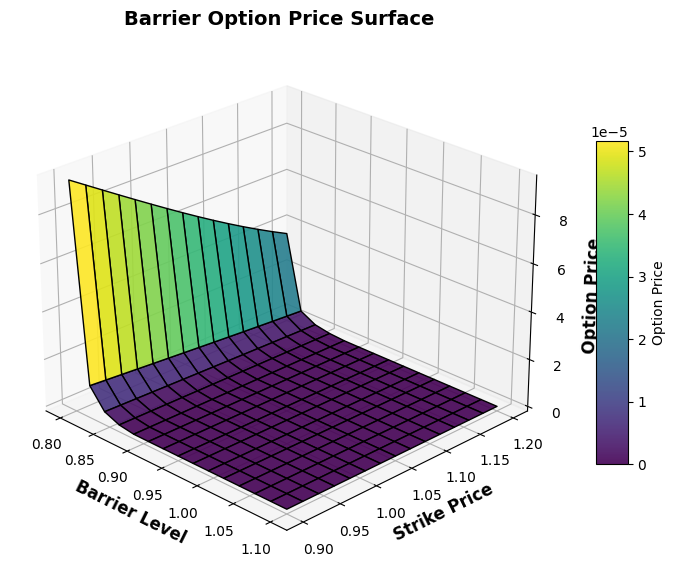

In [26]:
# Define a meaningful range of barrier and strike prices
barrier_levels = np.linspace(0.80, 1.10, 15)  # Barrier levels 
strike_prices = np.linspace(0.90, 1.20, 15)  # Strike prices
X, Y = np.meshgrid(barrier_levels, strike_prices)
Z = np.zeros_like(X)  # Store option prices

# Compute option prices efficiently
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        option_model = BinomialBarrierOption(
            spot_price=1.00,  # Assume FX spot price is 1.00 
            strike_price=Y[i, j], 
            time_to_maturity=1, 
            volatility=0.2, 
            domestic_rate=0.05, 
            foreign_rate=0.02, 
            barrier_level=X[i, j], 
            barrier_type="down-out", 
            option_type="call", 
            steps=500
        )
        Z[i, j] = option_model.price()

# Create 3D surface plot
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection="3d")
surface = ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor="black", alpha=0.9)

# Labels & Title
ax.set_title("Barrier Option Price Surface", fontsize=14, fontweight="bold")
ax.set_xlabel("Barrier Level", fontsize=12, fontweight="bold")
ax.set_ylabel("Strike Price", fontsize=12, fontweight="bold")
ax.set_zlabel("Option Price", fontsize=12, fontweight="bold")

# Color bar to indicate option price levels
fig.colorbar(surface, ax=ax, shrink=0.6, aspect=10, label="Option Price")


ax.view_init(elev=25, azim=-45) 
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)

# Show plot
plt.show()



## **Interpretation of the Barrier Option Price Surface**

#### **Key Observations**
- The **Z-axis (Option Price)** represents the value of a **Down-Out Call** option.
- **Barrier Level (X-Axis)**: As the **barrier level increases**, the **option price increases**.
  - A **higher barrier means a lower probability of being knocked out**, making the option **more valuable**.
- **Strike Price (Y-Axis)**: As the **strike price increases**, the **option price decreases**.
  - A **higher strike price makes a call option less valuable**, as it is less likely to be **in-the-money (ITM) at expiration**.


#### **Why Does the Barrier Affect the Option Price?**
- **Lower barriers** mean **higher knockout risk**, leading to **cheaper option prices**.
- **Higher barriers** reduce knockout risk, making the option behave **more like a vanilla call option**.
- If the **barrier is too close to the spot price**, the option is likely to be **knocked out early**, making it nearly worthless.


#### **Surface Shape & Slope**
- The plot **smoothly increases** along the barrier axis.
- A **steep drop** occurs when the barrier is too low (**e.g., near 0.80**), indicating that options with low barriers are often **knocked out before expiration**.

